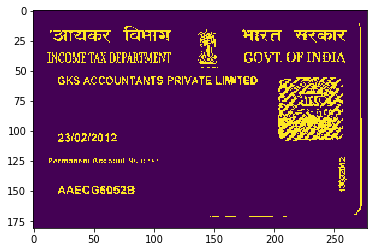

In [28]:
from skimage import data
from skimage import transform as tf
from skimage.feature import (match_descriptors, corner_peaks, corner_harris,
                             plot_matches, BRIEF)
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.filters import threshold_otsu 
import numpy as np
from skimage.segmentation import clear_border
from skimage.morphology import binary_dilation, binary_closing, square

# convert the image to gray
img = rgb2gray(imread("resources/pan/pan6.jpeg"))

#binarize the image
for_edge_detection_img = np.ones(img.shape)
r,c = img.shape
divider = 2
for ri in range(divider):
    for ci in range(divider):
        region = img[int((ri/divider)*r):int((ri/divider+1/divider)*r), int((ci/divider)*c):int((ci/divider+1/divider)*c)]
        thresh = threshold_otsu(region)
        for_edge_detection_img[int((ri/divider)*r):int((ri/divider+1/divider)*r), int((ci/divider)*c):int((ci/divider+1/divider)*c)] = region < thresh

plt.imshow(for_edge_detection_img)
plt.show()

In [29]:
from skimage.color import label2rgb
from skimage.measure import label, regionprops
import matplotlib.patches as mpatches

# label image regions
label_image = label(for_edge_detection_img)
al_areas = []
for region in regionprops(label_image):
    al_areas.append(region.area)

In [30]:
import math
math.floor(math.sqrt(np.median(al_areas)))

3

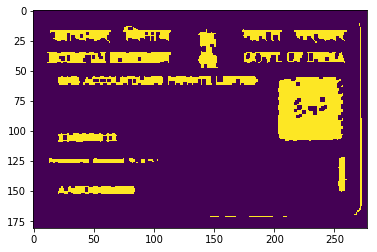

In [31]:
plt.imshow(binary_closing(for_edge_detection_img, square(math.floor(math.sqrt(np.median(al_areas))))))
plt.show()

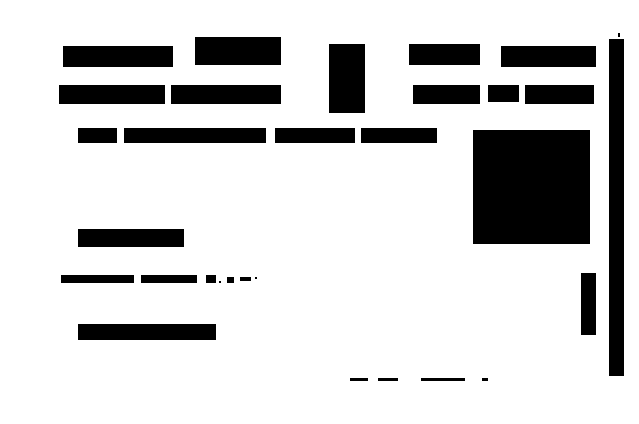

In [32]:
from skimage import img_as_float 

binary_closed = binary_closing(for_edge_detection_img, square(math.floor(math.sqrt(np.median(al_areas)))))
# label image regions
label_image = label(binary_closed)
fig, ax = plt.subplots(figsize=(10, 6))

image_black = img_as_float(np.ones(img.shape))

for region in regionprops(label_image):
    minr, minc, maxr, maxc = region.bbox
    if region.bbox_area < 0.1 * img.shape[0]*img.shape[1]:
        image_black[minr:maxr, minc:maxc] = 0

ax.imshow(image_black, cmap="gray")
ax.set_axis_off()
plt.tight_layout()
plt.show()

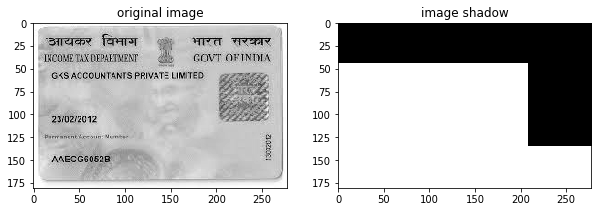

In [33]:
image_black_c = np.copy(image_black)
divider = 4
r, c = image_black_c.shape
for ri in range(divider):
    for ci in range(divider):
        region = image_black_c[int((ri/divider)*r):int((ri/divider+1/divider)*r), int((ci/divider)*c):int((ci/divider+1/divider)*c)]
        region_r, region_c = region.shape
        if np.sum(region)/(region_r*region_c) > 0.75:
            image_black_c[int((ri/divider)*r):int((ri/divider+1/divider)*r), int((ci/divider)*c):int((ci/divider+1/divider)*c)] = 1.0
        else:
            image_black_c[int((ri/divider)*r):int((ri/divider+1/divider)*r), int((ci/divider)*c):int((ci/divider+1/divider)*c)] = 0.0


fig, ax = plt.subplots(figsize=(10, 6), ncols=2)
ax[0].set_title("original image")
ax[0].imshow(img, cmap="gray")

ax[1].set_title("image shadow")
ax[1].imshow(image_black_c, cmap="gray")

In [4]:
from skimage import data
from skimage import transform as tf
from skimage.feature import (match_descriptors, corner_peaks, corner_harris,
                             plot_matches, BRIEF)
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.filters import threshold_otsu 
import numpy as np
from skimage.segmentation import clear_border
from skimage.morphology import binary_dilation, binary_closing, square
from skimage.color import label2rgb
from skimage.measure import label, regionprops
import matplotlib.patches as mpatches
import math
# let build a method to return the image mask.
def get_white_space_signature(image):
    if len(image.shape) != 2:
        print("must be a gray image.")
        return
    
    # step 1: binarize the image
    binarized_img = np.ones(image.shape) # create a white image
    r, c = image.shape
    
    divider = 2 # threshold 4 regions seperately.
    for ri in range(divider):
        for ci in range(divider):
            region = image[int((ri/divider)*r):int((ri/divider+1/divider)*r), int((ci/divider)*c):int((ci/divider+1/divider)*c)]
            thresh = threshold_otsu(region)
            binarized_img[int((ri/divider)*r):int((ri/divider+1/divider)*r), int((ci/divider)*c):int((ci/divider+1/divider)*c)] = region < thresh
    
    # step 2: identify the median size of bounding box
    label_image = label(binarized_img)
    al_areas = []
    for region in regionprops(label_image):
        al_areas.append(region.area)

    # step 3: binary close the image the size of average bounding box.
    binary_closed = binary_closing(binarized_img, square(math.floor(math.sqrt(np.median(al_areas)))))
    label_image = label(binary_closed)

    image_blank = np.ones((r,c))
    for region in regionprops(label_image):
        minr, minc, maxr, maxc = region.bbox
        # consider for cleaning only if the image is less than 10% of the image.
        if region.bbox_area < 0.1 * r*c:
            image_blank[minr:maxr, minc:maxc] = 0

    # step 4: generate the image mask by dividing the image into 16 regions.
    image_signature = []
    divider = 4
    for ri in range(divider):
        for ci in range(divider):
            region = image_blank[int((ri/divider)*r):int((ri/divider+1/divider)*r), int((ci/divider)*c):int((ci/divider+1/divider)*c)]
            region_r, region_c = region.shape
            if np.sum(region)/(region_r*region_c) > 0.75:
                image_signature.append(1)
            else:
                image_signature.append(0)

    return image_signature

In [5]:
print(get_white_space_signature(rgb2gray(imread("resources/pan/pan1.png"))))
print(get_white_space_signature(rgb2gray(imread("resources/pan/pan2.jpg"))))
print(get_white_space_signature(rgb2gray(imread("resources/pan/pan3.jpeg"))))
print(get_white_space_signature(rgb2gray(imread("resources/pan/pan4.jpeg"))))
print(get_white_space_signature(rgb2gray(imread("resources/pan/pan5.png"))))
print(get_white_space_signature(rgb2gray(imread("resources/pan/pan6.jpeg"))))

[0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1]
[0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0]
[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0]
[0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1]
